# SNN that detects Network bursts in a single channel
This notebook is a simple example of how to use a Spiking Neural Network (SNN) to detect a network burst in 2 channels 

## Definition of a network burst
A network burst is a sequence of spikes that occur in a short time window in a neural population. The definition of a network burst is not unique and depends on the context. 

In this notebook, we will **consider a channel burst a neuronal activity where 4 spikes occur within 20ms in the same channel**.

In this notebook, we will **consider a network burst a neuronal activity where 2 channels spike within 20ms from each other**.

In [1]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
import numpy as np

LIF?

Init signature: LIF(*args, **kwargs)
Docstring:     
Leaky-Integrate-and-Fire (LIF) neural Process.

LIF dynamics abstracts to:
u[t] = u[t-1] * (1-du) + a_in         # neuron current
v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
s_out = v[t] > vth                    # spike if threshold is exceeded
v[t] = 0                              # reset at spike

Parameters
----------
shape : tuple(int)
    Number and topology of LIF neurons.
u : float, list, numpy.ndarray, optional
    Initial value of the neurons' current.
v : float, list, numpy.ndarray, optional
    Initial value of the neurons' voltage (membrane potential).
du : float, optional
    Inverse of decay time-constant for current decay. Currently, only a
    single decay can be set for the entire population of neurons.
dv : float, optional
    Inverse of decay time-constant for voltage decay. Currently, only a
    single decay can be set for the entire population of neurons.
bias_mant : float, list, numpy.ndarray, optiona

## Create the Custom Input Layer

### Define function to read the input data from the csv file and generate the corresponding spike events

In [2]:
import os
import sys

# Add the parent directory to the path so it detects the utils module
module_path = os.path.abspath(os.path.join('..'))   
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd

def read_spike_events(file_path: str):
    """Reads the spike events from the input file and returns them as a numpy array

    Args:
        file_path (str): name of the file containing the spike events
    """
    spike_events = []

    try:
        # Read the spike events from the file
        df = pd.read_csv(file_path, header=None)

        # Detect errors
        if df.empty:
            raise Exception("The input file is empty")

        # Convert the scientific notation values to integers if any exist
        df = df.applymap(lambda x: int(float(x)) if (isinstance(x, str) and 'e' in x) else x)

        # Convert the dataframe to a numpy array
        spike_events = df.to_numpy()
        return spike_events[0]
    except Exception as e:
        print("Unable to read the input file: ", file_path, " error:", e)

    return spike_events

In [4]:
from utils.input import read_spike_events

# Call the function to read the spike events
file_path = "../lab_data/lab_data_1-8channels.csv"    # "./data/custom_frequent_spikes.csv"
spike_events = read_spike_events(file_path)
print("Spike events: ", spike_events.shape, spike_events[:10])

Spike events:  (3380, 2) [[3.0360e+02 7.0000e+00]
 [5.4090e+02 7.0000e+00]
 [7.8260e+02 7.0000e+00]
 [1.0638e+03 7.0000e+00]
 [1.4271e+03 1.0000e+00]
 [1.4304e+03 1.0000e+00]
 [1.4333e+03 1.0000e+00]
 [1.4347e+03 7.0000e+00]
 [1.4628e+03 1.0000e+00]
 [2.0500e+03 7.0000e+00]]


### Define the SpikeEvent Generator Interface

In [5]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

class SpikeEventGen(AbstractProcess):
    """Input Process that generates spike events based on the input file

    Args:
        shape (tuple): Shape of the output port
        file_name (str): Name of the file containing the spike events
    """
    def __init__(self, shape: tuple, spike_events: np.ndarray, name: str) -> None:
        super().__init__(name=name)
        self.s_out = OutPort(shape=shape)
        self.spike_events = Var(shape=spike_events.shape, init=spike_events)

## Define the Architecture of the Network

In [6]:
# Define the number of neurons in each LIF Layer
n1 = 2   # 2 neurons in the first layer
n2 = 1  # 1 neuron in the second layer

## Choose the LIF Models to use

In [7]:
use_refractory = True

### Create the LIF Processes

In [8]:
# Constants for the LIF Process
v_th = 1
v_init = 0
dv = 0.1
du = 0.2

if not use_refractory:
    # Create LIF1 process
    lif1 = LIF(shape=(n1,),  # There are 2 neurons
            vth=v_th,  # TODO: Verify these initial values
            v=v_init,
            dv=dv,    # Inverse of decay time-constant for voltage decay
            du=du,  # Inverse of decay time-constant for current decay
            bias_mant=0,
            bias_exp=0,
            name="lif1")

    # TODO: Check if we need to change the dynamics of the LIF2 process
    # Create LIF2 process
    lif2 = LIF(shape=(n2,),  # There is 1 neuron
            vth=v_th,  # TODO: Verify these initial values
            v=v_init,
            dv=dv,    # Inverse of decay time-constant for voltage decay
            du=du,  # Inverse of decay time-constant for current decay
            bias_mant=0,
            bias_exp=0,
            name="lif2")

### Create the Refractory LIF Processes

In [9]:
from lava.proc.lif.process import LIFRefractory
from lava.magma.core.process.process import LogConfig
import logging

# Constants for the LIF Process
v_th = 1.0
v_init = 0.0
dv = 0.1
du = 0.2
refrac_period = 10   # Number of time-steps for the refractory period

if use_refractory:
    # Create Refractory LIF1 process
    lif1 = LIFRefractory(shape=(n1,),  # There are 2 neurons
            vth=v_th,  # TODO: Verify these initial values
            v=v_init,
            dv=dv,    # Inverse of decay time-constant for voltage decay
            du=du,  # Inverse of decay time-constant for current decay
            bias_mant=0,
            bias_exp=0,
            refractory_period=refrac_period,
            name="lif1",
            # log_config=LogConfig(level=logging.DEBUG, level_console=logging.DEBUG, logs_to_file=False)
            )

    # TODO: Check if we need to change the dynamics of the LIF2 process
    # Create Refractory LIF2 process
    lif2 = LIFRefractory(shape=(n2,),  # There is 1 neuron
            vth=v_th,  # TODO: Verify these initial values
            v=v_init,
            dv=dv,    # Inverse of decay time-constant for voltage decay
            du=du,  # Inverse of decay time-constant for current decay
            bias_mant=0,
            bias_exp=0,
            refractory_period=refrac_period,
            name="lif2")

### Create the Dense Layers

In [10]:
# Create Dense Process to connect the input layer and LIF1
# create weights of the dense layer
dense_weights_input = np.eye(N=n1, M=n1)
# multiply the weights of the Dense layer by a constant
weights_scale_input = 0.1
dense_weights_input *= weights_scale_input
dense_input = Dense(weights=np.array(dense_weights_input), name="DenseInput")


# Create Dense Process to connect LIF1 and LIF2
# create weights of the dense layer connecting LIF1 and LIF2
dense_weights_middle = np.ones(shape=(n2, n1))
# multiply the weights of the Dense layer by a constant
weights_scale_middle = 0.5
# dense_weights_middle *= weights_scale_input     # Multiply by the same constant as the input layer to keep the same dynamics as LIF1
dense_weights_middle *= weights_scale_middle    # Multiply by a new constant to sum the inputs from all neurons in LIF1
# Create Dense Process to connect the two LIF layers
dense_middle = Dense(shape=(n1, n2),  # There are 2 neurons in the first layer and 1 in the second
              weights=np.array(dense_weights_middle),  # TODO: Check these weights
              name="Dense_LIF1-2")

### Map the input channels to the corresponding indexes in the input layer
Since the input channels in the input file may be of any number, we need to **map the input channels to the corresponding indexes in the input layer**. This is done by the `channel_map` dictionary.

In [11]:
# Map the channels of the input file to the respective index in the output list of SpikeEventGen
# channel_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7}
channel_map = {1: 0, 4: 1}

## Define constants related to the simulation time

In [12]:
init_offset = 5800      #  
virtual_time_step_interval = 1

num_steps = 300     # Number of steps to run the simulation

### Implement the `SpikeEventGenerator` Model

In [13]:
from lava.magma.core.model.py.model import PyLoihiProcessModel  # Processes running on CPU inherit from this class
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyOutPort

@implements(proc=SpikeEventGen, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeEventGenModel(PyLoihiProcessModel):
    """Spike Event Generator Process implementation running on CPU (Python)
    Args:
    """
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)   # IT IS POSSIBLE TO SEND FLOATS AFTER ALL
    spike_events: np.ndarray = LavaPyType(np.ndarray, np.ndarray)   # TODO: Check if we should keep it as a numpy array, or transform it to a list

    def __init__(self, proc_params) -> None:
        super().__init__(proc_params=proc_params)
        # print("spike events", self.spike_events.__str__())    # TODO: Check why during initialization the variable prints the class, while during run it prints the value
        self.curr_spike_idx = 0     # Index of the next spiking event to send
        self.virtual_time_step_interval = virtual_time_step_interval  # 1000    # Arbitrary time between time steps (in microseconds). This is not a real time interval (1000ms = 1s)
        self.init_offset = init_offset        # 698995               # Arbitrary offset to start the simulation (in microseconds)

    def run_spk(self) -> None:
        spike_data = np.zeros(self.s_out.shape) # Initialize the spike data to 0
        
        #print("time step:", self.time_step)
        # If the current simulation time is greater than the next spike event, send a spike
        currTime = self.init_offset + self.time_step*self.virtual_time_step_interval

        spiking_channels = set()   # List of channels that will spike at the same time
        while (self.curr_spike_idx < len(self.spike_events)) and currTime >= self.spike_events[self.curr_spike_idx][0]:  # Check if there are more than 1 spike events to send
            curr_channel = self.spike_events[self.curr_spike_idx][1]

            # Check if the channel is valid (belongs to a channel in the channel_map therefore it has an output index)
            if curr_channel not in channel_map:
                self.curr_spike_idx += 1
                continue    # Skip the current spike event

            # Check if the next spike belongs to a channel that will already spike at the same time
            if curr_channel in spiking_channels:    # If the channel is already spiking, we stop the spikes for this time step
                break

            # Add the channel to the list of spiking channels
            spiking_channels.add(curr_channel)

            # Send a spike
            out_idx = channel_map[curr_channel]     # Map the channel to the output index
            if out_idx < self.s_out.shape[0]:   # Check if the channel is valid
                spike_data[out_idx] = 1.0   # Send a spike  (value corresponds to the punctual current of the spike event)

            # Move to the next spike event
            self.curr_spike_idx += 1

        if len(spiking_channels) > 0:   # Print the spike event if there are any spikes
            print(f"sending spike event at time: {currTime}({self.time_step}) last spike idx: {self.curr_spike_idx-1} spike time: {self.spike_events[self.curr_spike_idx-1][0]}")

        # Send spikes
        # print("sending spike_data: ", spike_data, " at step: ", self.time_step)
        self.s_out.send(spike_data)

        # Stop the Process if there are no more spike events to send. (It will stop all the connected processes)
        # TODO: Should it be another process that stops the simulation? Such as the last LIF process
        # if self.curr_spike_idx >= 5: # len(self.spike_events):
        #    self.pause()


## Connect the Layers
To define the connectivity between the `SpikeGenerator` and the first `LIF` population, we use another `Dense` Layer.

In [14]:
# Create the Input Process
spike_event_gen = SpikeEventGen(shape=(n1,), spike_events=spike_events, name="CustomInput")

# If I connect the SpikeEventGen to the Dense Layer, the a_out value of the custom input will be rounded to 0 or 1 in the Dense Layer (it will not be a float) 
# However, setting the Dense weights to a float works instead
# Connect the SpikeEventGen to the Dense Layer
spike_event_gen.s_out.connect(dense_input.s_in)

# Connect the Dense_Input to the LIF1 Layer
dense_input.a_out.connect(lif1.a_in)

# Connect the LIF1 Layer to the Dense Layer
lif1.s_out.connect(dense_middle.s_in)   # Connect the output of the first LIF layer to the Dense Layer
# Connect the Dense Layer to the LIF2 Layer
dense_middle.a_out.connect(lif2.a_in)   # Connect the output of the Dense Layer to the second LIF Layer

### Take a look at the connections in the Input Layer

In [15]:
for proc in [spike_event_gen, dense_input, lif1, dense_middle, lif2]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: CustomInput Port Name: s_out Size: 2
Proc: DenseInput Port Name: s_in  Size: 2
Proc: DenseInput Port Name: a_out Size: 2
Proc: lif1  Port Name: a_in  Size: 2
Proc: lif1  Port Name: s_out Size: 2
Proc: Dense_LIF1-2 Port Name: s_in  Size: 2
Proc: Dense_LIF1-2 Port Name: a_out Size: 1
Proc: lif2  Port Name: a_in  Size: 1
Proc: lif2  Port Name: s_out Size: 1


### Look at the weights of the Dense Layers

In [16]:
# Weights of the Input Dense Layer
dense_input.weights.get()

array([[0.1, 0. ],
       [0. , 0.1]])

In [17]:
# Weights of the Dense Layer between LIF1 and LIF2
dense_middle.weights.get()

array([[0.5, 0.5]])

### Record Internal Vars over time
To record the evolution of the internal variables over time, we need a `Monitor`. For this example, we want to record the membrane potential of the `LIF` Layer, hence we need 1 `Monitors`.

We can define the `Var` that a `Monitor` should record, as well as the recording duration, using the `probe` function

In [18]:
from lava.proc.monitor.process import Monitor

monitor_lif1_v = Monitor()
monitor_lif1_u = Monitor()
monitor_lif2_v = Monitor()
monitor_lif2_u = Monitor()

# Connect the monitors to the variables we want to monitor
monitor_lif1_v.probe(lif1.v, num_steps)
monitor_lif1_u.probe(lif1.u, num_steps)
monitor_lif2_v.probe(lif2.v, num_steps)
monitor_lif2_u.probe(lif2.u, num_steps)

## Execution
Now that we have defined the network, we can execute it. We will use the `run` function to execute the network.

### Run Configuration and Conditions

In [19]:
from lava.magma.core.run_conditions import RunContinuous, RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

# run_condition = RunContinuous()   # TODO: Change to this one
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")   # TODO: Check why we need this select_tag="floating_pt"

### Execute

In [20]:
lif1.run(condition=run_condition, run_cfg=run_cfg)

sending spike event at time: 5801(1) last spike idx: 4 spike time: 1427.1
sending spike event at time: 5802(2) last spike idx: 5 spike time: 1430.4
sending spike event at time: 5803(3) last spike idx: 7 spike time: 1434.7
sending spike event at time: 5804(4) last spike idx: 11 spike time: 2286.2000000000003
sending spike event at time: 5805(5) last spike idx: 12 spike time: 2791.1
sending spike event at time: 5806(6) last spike idx: 15 spike time: 2794.2000000000003
sending spike event at time: 5807(7) last spike idx: 16 spike time: 2800.6
sending spike event at time: 5808(8) last spike idx: 17 spike time: 2874.1
sending spike event at time: 5809(9) last spike idx: 19 spike time: 2884.5
sending spike event at time: 5810(10) last spike idx: 21 spike time: 2886.3
sending spike event at time: 5811(11) last spike idx: 22 spike time: 2887.1
sending spike event at time: 5812(12) last spike idx: 23 spike time: 2896.9
sending spike event at time: 5813(13) last spike idx: 24 spike time: 2899.4


sending spike event at time: 5888(88) last spike idx: 54 spike time: 5888.0
sending spike event at time: 5891(91) last spike idx: 55 spike time: 5890.5
sending spike event at time: 5899(99) last spike idx: 57 spike time: 5898.900000000001
sending spike event at time: 5902(102) last spike idx: 58 spike time: 5901.2
sending spike event at time: 5904(104) last spike idx: 59 spike time: 5903.7
sending spike event at time: 5905(105) last spike idx: 60 spike time: 5904.6
sending spike event at time: 5906(106) last spike idx: 62 spike time: 5906.0
sending spike event at time: 5908(108) last spike idx: 64 spike time: 5908.0
sending spike event at time: 5909(109) last spike idx: 65 spike time: 5908.6
sending spike event at time: 5911(111) last spike idx: 67 spike time: 5910.3
sending spike event at time: 5912(112) last spike idx: 68 spike time: 5911.400000000001
sending spike event at time: 5913(113) last spike idx: 69 spike time: 5912.900000000001
sending spike event at time: 5914(114) last sp

### Retrieve recorded data

In [21]:
data_lif1_v = monitor_lif1_v.get_data()
data_lif1_u = monitor_lif1_u.get_data()
data_lif2_v = monitor_lif2_v.get_data()
data_lif2_u = monitor_lif2_u.get_data()

data_lif1 = data_lif1_v.copy()
data_lif1["lif1"]["u"] = data_lif1_u["lif1"]["u"]   # Merge the dictionaries to contain both voltage and current

data_lif2 = data_lif2_v.copy()
data_lif2["lif2"]["u"] = data_lif2_u["lif2"]["u"]   # Merge the dictionaries to contain both voltage and current


In [22]:
lif1

In [23]:
data_lif2

{'lif2': {'v': array([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.

In [24]:
# Check the shape to verify if it is printing the voltage for every step
print(len(data_lif1['lif1']['v']))     # Indeed, there are 300 values (same as the number of steps we ran the simulation for)

print(len(data_lif2['lif2']['v']))

300
300


### Plot the recorded data

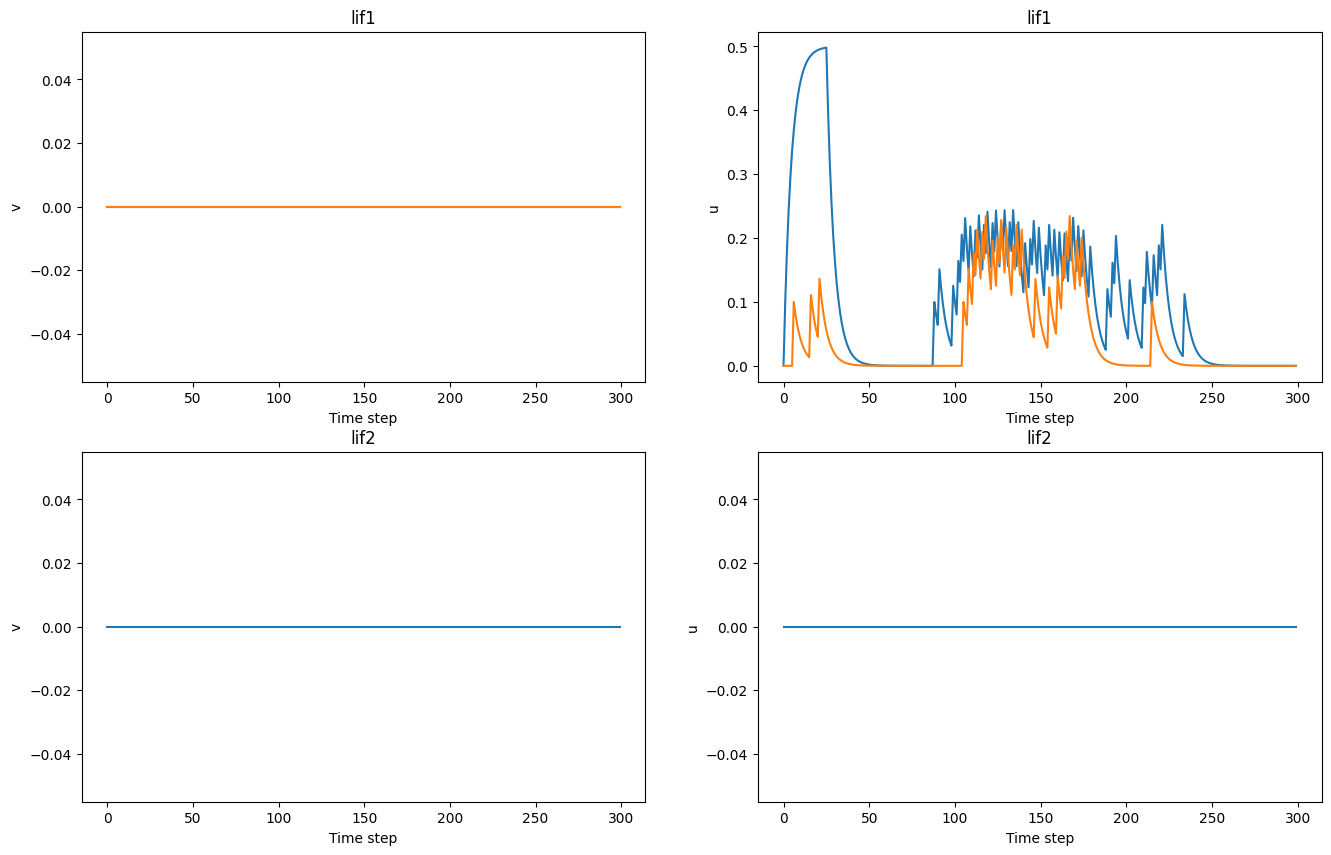

In [25]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitored variable
fig = plt.figure(figsize=(16, 10))
ax0 = fig.add_subplot(221)
ax0.set_title('Voltage (V) / time step')
ax1 = fig.add_subplot(222)
ax1.set_title('Current (U) / time step')

ax2 = fig.add_subplot(223)
ax2.set_title('Voltage (V) / time step')
ax3 = fig.add_subplot(224)
ax3.set_title('Current (U) / time step')


# Plot the data
monitor_lif1_v.plot(ax0, lif1.v)
monitor_lif1_u.plot(ax1, lif1.u)
monitor_lif2_v.plot(ax2, lif2.v)
monitor_lif2_u.plot(ax3, lif2.u)


## Find the timesteps where the network bursts occur

In [26]:
from utils.data_analysis import find_spike_times

voltage_arr_1 = np.array(data_lif1['lif1']['v'])
voltage_arr_2 = np.array(data_lif2['lif2']['v'])
print("voltage arrays shapes:", voltage_arr_1.shape, voltage_arr_2.shape)

# Call the find_spike_times util function that detects the spikes in a voltage array
spike_times_lif1 = find_spike_times(voltage_arr_1, v_th)
spike_times_lif2 = find_spike_times(voltage_arr_2, v_th)


print("Spike times LIF1: ", spike_times_lif1)
print("Spike times LIF2: ", spike_times_lif2)

voltage arrays shapes: (300, 2) (300, 1)
Spike times LIF1:  []
Spike times LIF2:  []


## View the Voltage and Current dynamics with an interactive plot

Grab the data from the recorded variables

In [27]:
# LIF1 variables
lif1_voltage_vals = data_lif1['lif1']['v']
lif1_current_vals = data_lif1['lif1']['u']

print("lif1 voltage shape:", len(lif1_voltage_vals))
# print("voltage head: ", lif1_voltage_vals[:10])


# LIF2 variables
lif2_voltage_vals = data_lif2['lif2']['v']
lif2_current_vals = data_lif2['lif2']['u']

print("lif2 voltage shape:", len(lif2_voltage_vals))

lif1 voltage shape: 300
lif2 voltage shape: 300


## Assemble the values to be plotted

In [28]:
from utils.line_plot import create_fig  # Import the function to create the figure
from bokeh.models import Range1d

# Define the x and y values
x = [val + init_offset for val in range(num_steps)]

v_y1 = [val[0] for val in lif1_voltage_vals]
v_y2 = [val[1] for val in lif1_voltage_vals]

# Create the plot
voltage_lif1_y_arrays = [(v_y1, "Ch. 1"), (v_y2, "Ch. 4")]    # List of tuples containing the y values and the legend label
# Define the box annotation parameters
box_annotation_voltage = {
    "bottom": 0,
    "top": v_th,
    "left": 0,
    "right": num_steps,
    "fill_alpha": 0.03,
    "fill_color": "green"
}

# Create the LIF1 Voltage
voltage_lif1_plot = create_fig(
    title="LIF1 Voltage dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Voltage (V)',
    x=x, 
    y_arrays=voltage_lif1_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    box_annotation_params=box_annotation_voltage,
    y_range=Range1d(-0.05, 1.05)
)


# Create the LIF1 Current
u_y1 = [val[0] for val in lif1_current_vals]
u_y2 = [val[1] for val in lif1_current_vals]
current_lif1_y_arrays = [(u_y1, "Ch. 1"), (u_y2, "Ch. 4")]    # List of tuples containing the y values and the legend label
current_lif1_plot = create_fig(
    title="LIF1 Current dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Current (U)',
    x=x, 
    y_arrays=current_lif1_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    x_range=voltage_lif1_plot.x_range,    # Link the x-axis range to the voltage plot
)

# bplt.show(voltage_lif1_plot)

In [29]:
v_y1 = [val[0] for val in lif2_voltage_vals]

# Create the plot
voltage_lif2_y_arrays = [(v_y1, "Ch. 1")]    # List of tuples containing the y values and the legend label
# Define the box annotation parameters
box_annotation_voltage = {
    "bottom": 0,
    "top": v_th,
    "left": 0,
    "right": num_steps,
    "fill_alpha": 0.03,
    "fill_color": "green"
}

# Create the LIF2 Voltage
voltage_lif2_plot = create_fig(
    title="LIF2 Voltage dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Voltage (V)',
    x=x, 
    y_arrays=voltage_lif2_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    box_annotation_params=box_annotation_voltage,
    y_range=Range1d(-0.05, 1.05),
    x_range=voltage_lif1_plot.x_range,    # Link the x-axis range to the voltage plot
)


# Create the LIF2 Current
u_y1 = [val[0] for val in lif2_current_vals]
current_lif2_y_arrays = [(u_y1, "Output")]    # List of tuples containing the y values and the legend label
current_lif2_plot = create_fig(
    title="LIF2 Current dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Current (U)',
    x=x, 
    y_arrays=current_lif2_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    x_range=voltage_lif1_plot.x_range,    # Link the x-axis range to the voltage plot
)

# bplt.show(voltage_lif1_plot)

## Show the Plots assembled in a grid

In [30]:
import bokeh.plotting as bplt
from bokeh.layouts import gridplot

showPlot = True
if showPlot:
    # Create array of plots to be shown
    plots = [voltage_lif1_plot, current_lif1_plot, voltage_lif2_plot, current_lif2_plot]

    if len(plots) == 1:
        grid = plots[0]
    else:   # Create a grid layout
        grid = gridplot(plots, ncols=2, sizing_mode="stretch_both")

    # Show the plot
    bplt.show(grid)

## Export the plot to a file

In [31]:
export = True

if export:
    file_path = "./results/lab_net_burst_ch1and4_2spikes_10ms_20refrac_1_0_0.1_0.2.html"

    # Customize the output file settings
    bplt.output_file(filename=file_path, title="Channel Burst detection - LIF1 Voltage and Current dynamics")

    # Save the plot
    bplt.save(grid)

## Stop the Runtime

In [32]:
lif1.stop()